# Exploratory Factor Analysis (EFA) demo
This notebook is designed to explain EFA and demonstrate how to perform it in Python.

Factor analysis (FA) is a part of a class of dimensionality reduction techniques for data with high number of observations and/or variables. While it is similar to techniques like prinicpal component analysis (PCA), PCA extracts components that are linear combinations of the observed variables, while FA treats the observed data as a linear combination of hidden underlying factors. FA is therefore fairly hypothesis-driven, with some idea of the number of factors to expect and what those factors may be. In exploratory factor analysis (EFA) there is some idea of the underlying factor structure, but the true number of factors or what they may represent is not as well understood.

In [15]:
#Prep work
import pandas as pd
import pickle as pkl
import matplotlib as mpl
import seaborn as sns
import matplotlib.pyplot as plt

from proj_utils import node_color_generator, plotBrains
from factor_analysis import efaUtils as utils
from factor_analyzer import FactorAnalyzer

with open(r"./pData.pkl", "rb") as f:
    project_data = pkl.load(f)
    
#Support functions for plotting
def seaborn_set():
    sns.set()
    sns.set_style("darkgrid", {"axes.facecolor": ".3", "grid.color": ".4"})
def matplot_set():
    mpl.rcParams.update(mpl.rcParamsDefault)

## Data
We will use cross-correlation matrices as our input into EFA (see k-means notebook). 

In [21]:
file = r"./notebook_data/seed_functional_profiles.csv"
file_df = pd.read_csv(file,index_col=0)
seedList = project_data['newNames']

corr_df = pd.DataFrame(file_df.values.T).corr()
#corrDf = corr_prep.corr()
data = utils.centerMat(corr_df.values)
data_df = pd.DataFrame(data, columns=seedList, index=seedList)
data_df.head()

,pMCC_i3_R,dPCC_i1_R,dPCC_i2_R,dPCC_i3_R,vPCC_i1_R,RSC_R,pMCC_i3_L,dPCC_i1_L,dPCC_i2_L,dPCC_i3_L,...,aMCC_s1_R,pgACC_s3_R,pgACC_s2_R,pMCC_s2_L,pMCC_s1_L,aMCC_s3_L,aMCC_s2_L,aMCC_s1_L,pgACC_s3_L,pgACC_s2_L
pMCC_i3_R,0.498017,0.109613,-0.020299,0.021766,0.012812,-0.076362,0.135733,0.135979,0.047869,0.016455,...,0.139090,0.177793,0.051801,0.129969,0.102949,0.017843,-0.043510,0.037181,0.129101,0.218169
dPCC_i1_R,0.136379,0.471251,0.338242,0.173024,0.212275,0.228940,0.092734,0.403342,0.284188,0.104941,...,0.183998,0.102194,0.186956,-0.028541,-0.199871,-0.097627,0.032979,0.113853,0.116628,0.232555
dPCC_i2_R,-0.089263,0.242512,0.566981,0.272568,0.220855,0.243632,-0.024956,0.185458,0.418144,0.162810,...,-0.034899,-0.053593,0.065161,-0.062418,-0.295060,-0.217242,-0.083917,-0.046228,-0.063804,0.032851
dPCC_i3_R,-0.033087,0.091405,0.286679,0.552870,0.405190,0.306727,0.022931,0.108615,0.293399,0.463006,...,-0.035977,0.074670,0.206557,-0.159591,-0.380187,-0.300846,-0.109777,-0.093000,-0.014501,0.020998
vPCC_i1_R,-0.066722,0.105976,0.210286,0.380510,0.577550,0.391109,-0.014063,0.058930,0.135545,0.329079,...,-0.039167,0.041551,0.176012,-0.218849,-0.446803,-0.453186,-0.290167,-0.221255,-0.087327,-0.057627


## Determine number of factors using PCA
There are a few ways to determine the number of factors to extract in EFA. We chose to run a simple PCA using sklearn's PCA function and run permutation testing. Permutation testing involves the shuffling the rows within each column and re-running the PCA. Doing this destroys the correlational structure of the dataset, allowing us to build a sort of null distribution to which we can compare our PCA results to. 

After extracting eigenvalues/components, we permuted the dataset 1000 times created eigenvalue distributions for each component. We plotted the original eigenvalues on a scree plot, and denoted any eigenvalues with p < .05 with a blue point. As the scree plot shows, our original PCA extracted 14 components, but only the first three eigenvalues survived permutation testing. Therefore we chose to use 3 as the number of factors for FA.  

In [17]:
eigs, p, _ = utils.permPCA(data_df.values)
utils.plotScree(eigs, p, kaiser=False)

## Factor analysis with 3 factors

Now that we have a choice for number of factors to extract, we'll run a FA on our data using the FactorAnalyzer module by ETS.

In [18]:
fa = FactorAnalyzer() #initialize a FactorAnalyzer instance
fa.analyze(data_df, n_factors=3, rotation=None) #run a factor analysis, using no rotation

loadings = fa.loadings
original_eigs, common_eigs = fa.get_eigenvalues()

Since the goal of our FA is to "cluster" our seeds, we can compare the performance of our FA to our k-means results.

<Figure size 1000x1000 with 0 Axes>

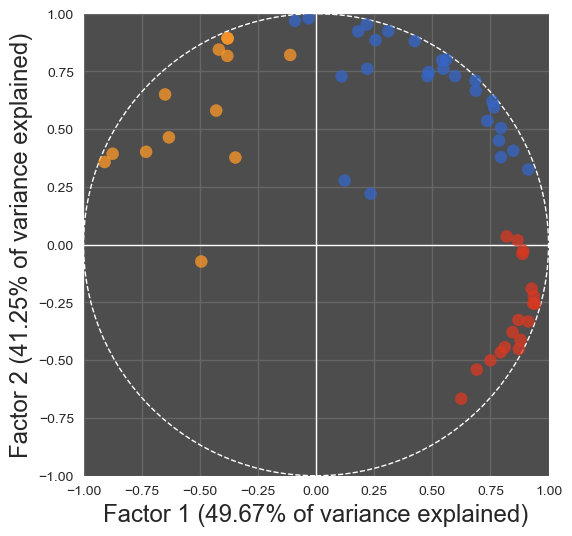

In [19]:
k_means_results = pd.read_csv(r"./notebook_data/3kSolution.csv", header=None, index_col=0)
k_means_coloring = node_color_generator(project_data['catColors'], k_means_results.values)

plt.clf()
seaborn_set() #seaborn asthetics
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)
utils.plotFS(loadings.values[:, 0:2], common_eigs.values, ax=ax, col=k_means_coloring)
plt.show()

The circle of correlation plot seems to align with our k-means analysis, though the interpretation of the loadings could be aided by a rotation (see Varimax rotation section). 

Regardless, one advantage of FA is that we can be more fine-grained in how we interpret our "clusters". First we'll project our factor loadings into a color space, then compare our FA results to the k-means results.

<Figure size 640x480 with 0 Axes>

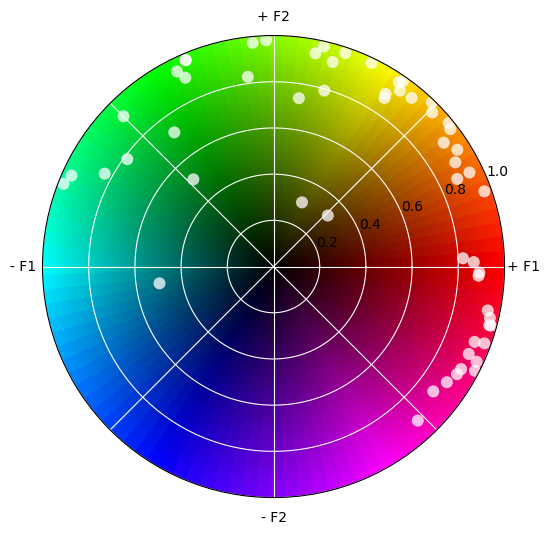

In [10]:
plt.clf()
matplot_set() #reset to matplotlib asthetics
R, theta, rgb = utils.createColorSpace(loadings.values[:, 0:2]) #converting factor loadings into polar coordinates
fig = plt.figure(figsize=(6, 6))
fig.patch.set_facecolor('w')

ax = fig.add_subplot(111, projection='polar')
utils.createColorLegend(R, theta, ax=ax) 
plt.grid(True,c='w')
plt.show()

Now let's compare FA and k-means on the brain.

C:\Users\ixa080020\AppData\Local\Continuum\anaconda3\lib\site-packages\nilearn\plotting\displays.py:1307: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if node_color == 'auto':


<Figure size 640x480 with 0 Axes>

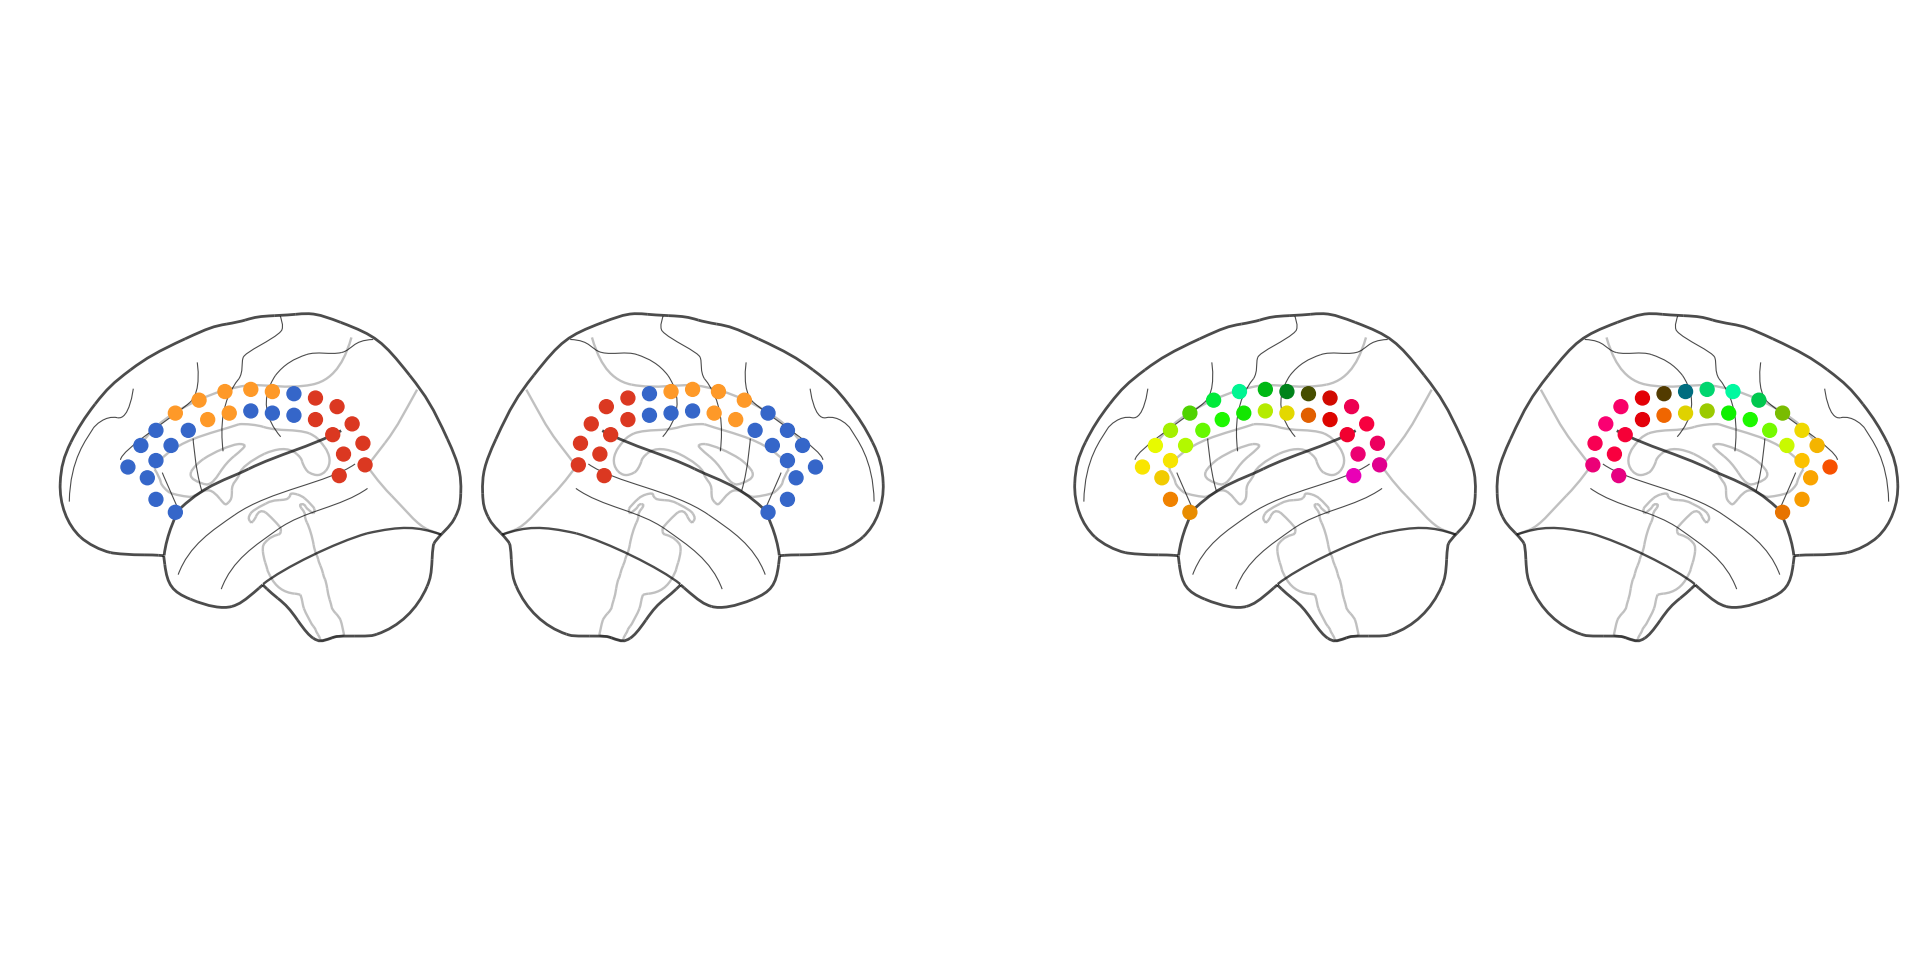

In [11]:
plt.clf()
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 12))

plotBrains(project_data['coordsMNI'], k_means_coloring, node_size=100, axis=ax1, plot_flag=False)
plotBrains(project_data['coordsMNI'], rgb, node_size=100, axis=ax2, plot_flag=False)
plt.show()

There seems to be a general correspondence between the k-means clustering solution and how our seeds load onto factors in FA. However, the story may be clearer if we rotate our factor space.

## Factor analysis with a varimax rotation

Next we will be using a varimax rotation, which rotates the factors such that high factor loadings are emphasized while low factor loadings are de-emphasized. 

In [12]:
fa = FactorAnalyzer()
fa.analyze(data_df, n_factors=3, rotation='varimax')

loadings = fa.loadings
original_eigs, common_eigs = fa.get_eigenvalues()

Like before, we'll plot the rotated factor loadings and use the k-means solution to color the seeds. Then we'll show the projection of the rotated loadings into color space.

<Figure size 640x480 with 0 Axes>

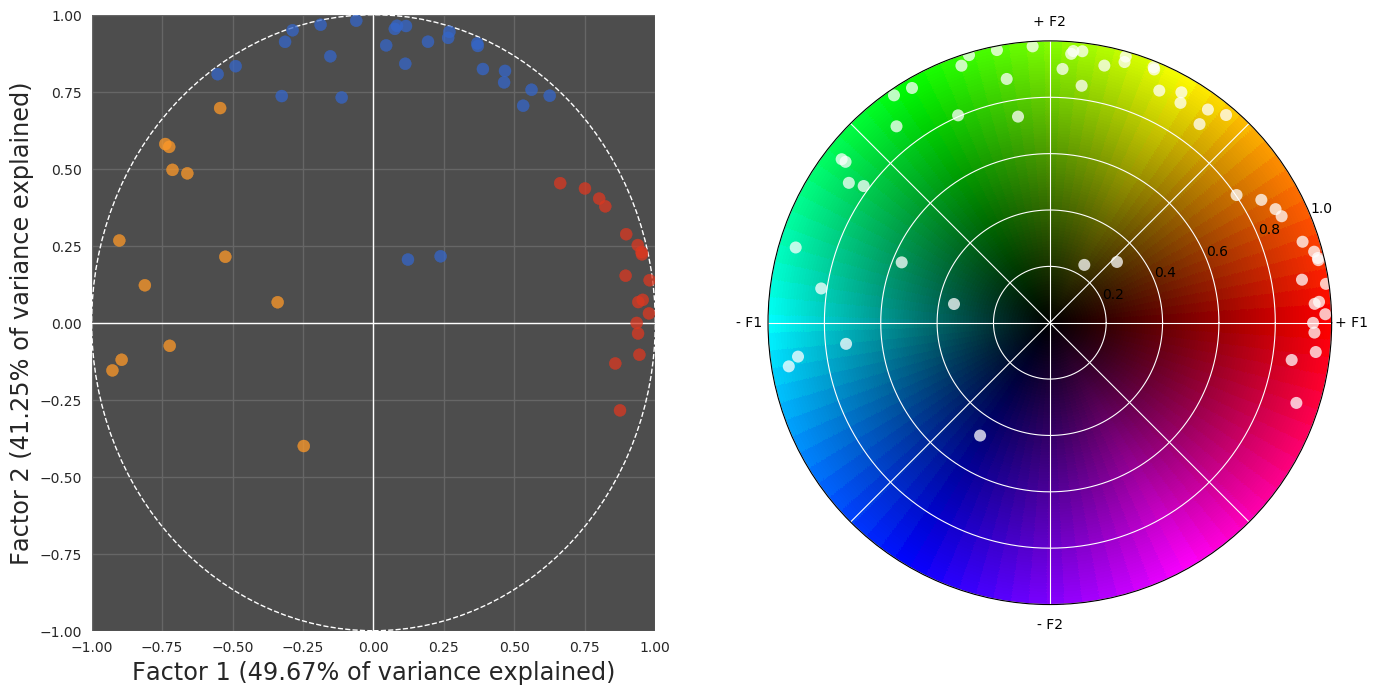

In [13]:
plt.clf()
fig = plt.figure(figsize=(16, 8))

seaborn_set()
ax1 = fig.add_subplot(121)
utils.plotFS(loadings.values[:, 0:2], common_eigs.values, col=k_means_coloring, ax=ax1)

matplot_set()
R, theta, rgb = utils.createColorSpace(loadings.values[:, 0:2])
ax2 = fig.add_subplot(122, projection='polar')
utils.createColorLegend(R, theta, ax=ax2)
plt.grid(True,c='w')

plt.show()

The rotation has made our factors much clearer. Red and yellow seeds correlate highly with the first factor, while the second factor is mainly describing the blue seeds. 

Finally, we'll plot the colorspace-projected factor loadings onto the brain (keeping the k-means solution as a reference).

C:\Users\ixa080020\AppData\Local\Continuum\anaconda3\lib\site-packages\nilearn\plotting\displays.py:1307: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if node_color == 'auto':


<Figure size 640x480 with 0 Axes>

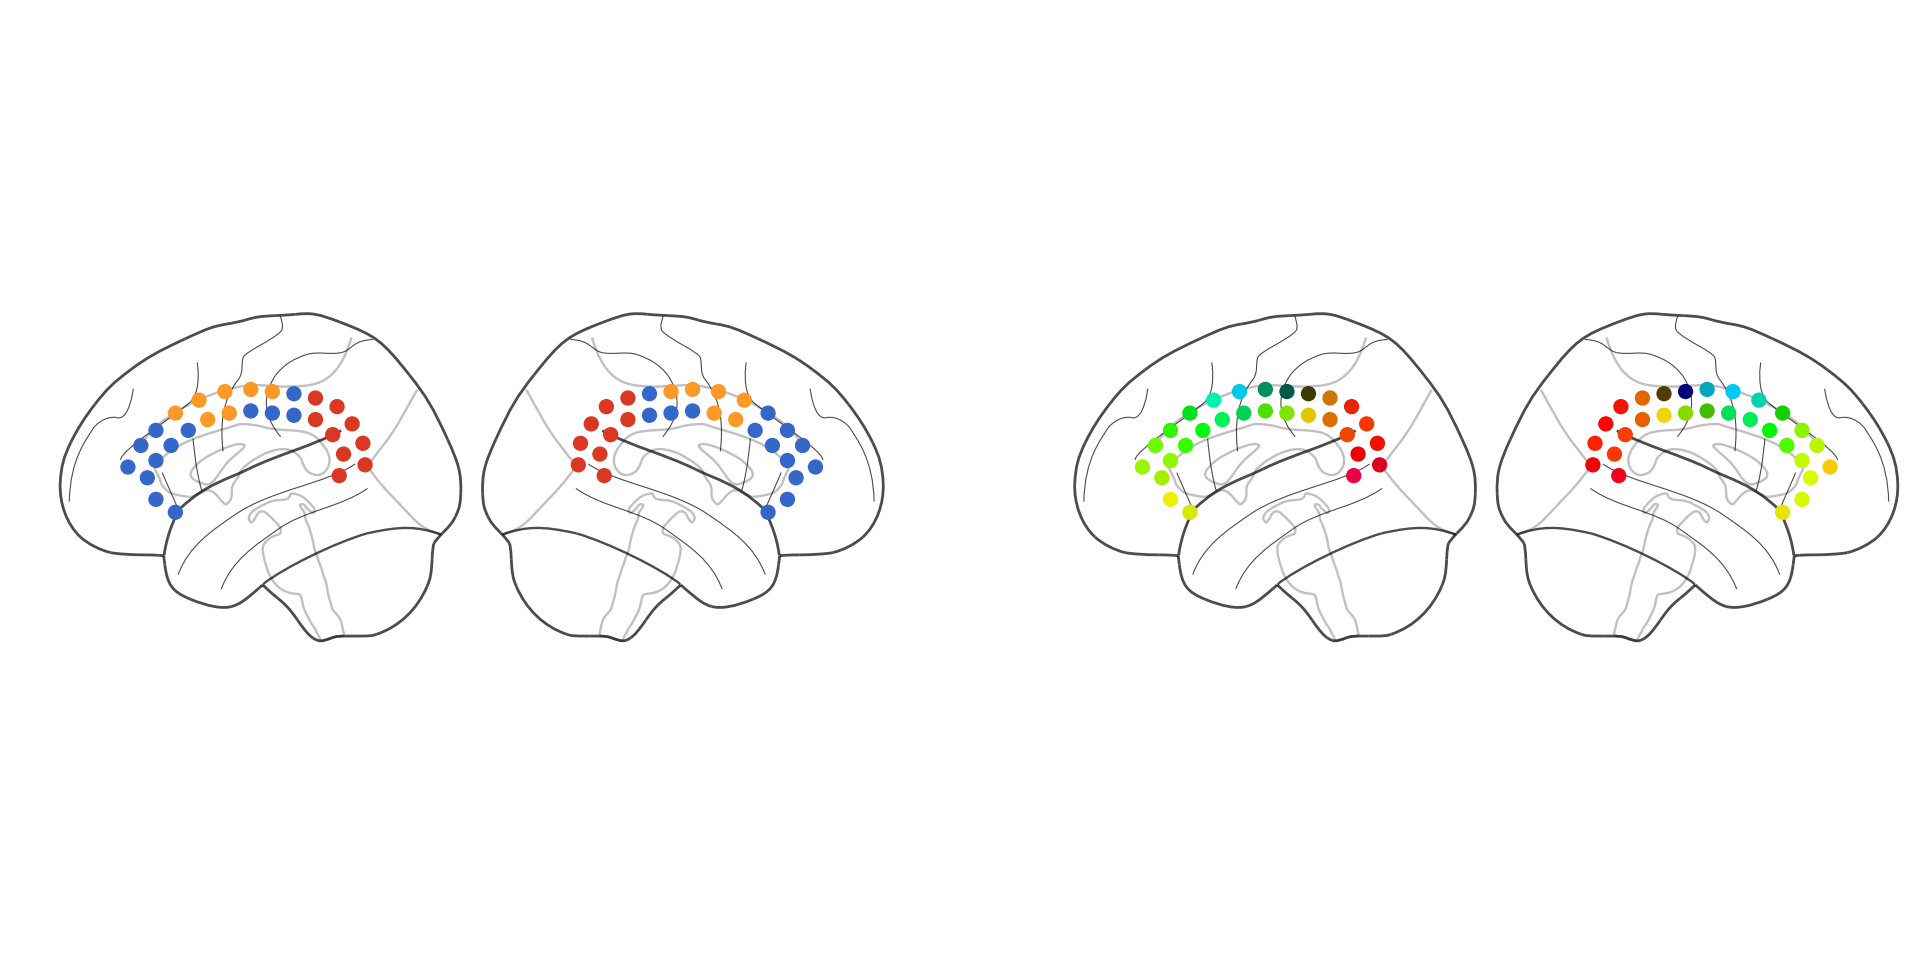

In [14]:
plt.clf()
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 12))

plotBrains(project_data['coordsMNI'], k_means_coloring, node_size=100, axis=ax1, plot_flag=False)
plotBrains(project_data['coordsMNI'], rgb, node_size=100, axis=ax2, plot_flag=False)
plt.show()